In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from scipy.constants import h,k,c
from scipy.optimize import curve_fit, brute, minimize
from astropy import units as u
from astropy.modeling.blackbody import blackbody_lambda, blackbody_nu
import time
import emcee
import sedfitter

import astropy
print astropy.__version__

import scipy
print scipy.__version__

import matplotlib
print matplotlib.__version__

print "Dependencies imported"

2.0.2
0.19.1
2.1.0
Dependencies imported


In [16]:
filternamevec = ['PSg','PSr','PSi','PSz','PSy','Gaia','BJohnson','VJohnson','SDSSg','SDSSr','SDSSi','J','H','K','W1','W2','W3','W4']
filterzps = [3631., 3631., 3631., 3631., 3631., 2861.3, 4000.87, 3597.28, 3631., 3631., 3631., 1594., 1024., 666.7, 309.54, 171.787, 31.674, 8.363]
filtercentwav = [0.4810, 0.6170, 0.7520, 0.8660, 0.9620, 0.673, 0.4361, 0.5448, 0.4770, 0.6231, 0.7625, 1.235, 1.662, 2.159, 3.35, 4.60, 11.56, 22.08]

filterzps_short = filterzps[-7:]
#filterzps_nops = filterzps[5:]
#filterzps_nogaia = filterzps[6:]

filterzps_dict = {filtercentwav[i]: filterzps[i] for i in range(len(filtercentwav))}

class FullSubject:
    def __init__(self, vec):
        self.zooniverse_id = vec[8]
        self.wiseid = vec[7]
        self.ra = float(vec[1])
        self.dec = float(vec[2])
        self.glong = float(vec[9])
        self.glat = float(vec[10])

        self.jmag = float(vec[19])
        self.jmagerr = float(vec[20])
        self.hmag = float(vec[21])
        self.hmagerr = float(vec[22])
        self.kmag = float(vec[23])
        self.kmagerr = float(vec[24])
        tempw1mag = float(vec[11])
        tempw1magerr = float(vec[12])
        tempw2mag = float(vec[13])
        tempw2magerr = float(vec[14])
        self.w3mag = float(vec[15])
        self.w3magerr = float(vec[16])
        self.w4mag = float(vec[17])
        self.w4magerr = float(vec[18])
        
        if tempw1mag > 8.:
            self.w1mag = tempw1mag + 0.
            self.w1magerr = tempw1magerr + 0.
        else:
            self.w1mag = tempw1mag + (0. - 0.1359 + (0.0396*tempw1mag) - (0.0023*tempw1mag*tempw1mag)) - 0.031
            self.w1magerr = (((1. + 0.0396 - (0.0046*tempw1mag))**2) * (tempw1magerr**2))**0.5
            
        if tempw2mag > 6.7:
            self.w2mag = tempw2mag + 0.
            self.w2magerr = tempw2magerr + 0.
        elif tempw2mag > 5.4:
            self.w2mag = tempw2mag + (-0.3530 + (0.8826*tempw2mag) - (0.2380*(tempw2mag**2)) + (0.0170*(tempw2mag**3))) + 0.004
            self.w2magerr = (((1. + 0.8826 - (0.4760 * tempw2mag) + (0.0510 * (tempw2mag**2)))**2) * (tempw2magerr**2))**0.5
        else:
            self.w2mag = tempw2mag + (1.5777 - (0.3495*tempw2mag) + (0.0160*(tempw2mag**2))) + 0.004
            self.w2magerr = (((1. - 0.3495 + (2.*0.0160*tempw2mag))**2) * (tempw2magerr**2))**0.5

        self.psgmag = float(vec[54])
        self.psgmagerr = float(vec[55])
        self.psimag = float(vec[56])
        self.psimagerr = float(vec[57])
        self.psrmag = float(vec[58])
        self.psrmagerr = float(vec[59])
        self.psymag = float(vec[60])
        self.psymagerr = float(vec[61])
        self.pszmag = float(vec[62])
        self.pszmagerr = float(vec[63])
        
        self.has_ps_gminr = (not math.isnan(self.psgmag)) and (not math.isnan(self.psrmag))
        if self.has_ps_gminr:
            self.psgminr = self.psgmag - self.psrmag
            self.psgminrerr = ((self.psgmagerr**2) + (self.psrmagerr**2))**0.5
        else:
            self.psgminr = float('NaN')
        
        self.sourcevec = vec
        
        self.gaiamag = float(vec[43])
        self.gaiamagerr = float(vec[45])
        #if not math.isnan(float(vec[80])):
        #    self.bjmag = float(vec[80])
        #    self.bjmagerr = float(vec[81])
        #elif not math.isnan(float(vec[35])) and (float(vec[35]) > 0.) and (float(vec[35]) < 5.) and (float(vec[29]) < 50.):
        #    self.bjmag = float(vec[29])
        #    self.bjmagerr = float(vec[35])
        self.bjmag_tycho = float(vec[80])
        self.bjmagerr_tycho = float(vec[81])        
        self.vjmag_tycho = float(vec[82])
        self.vjmagerr_tycho = float(vec[83])
        
        self.has_tycho_vmag = (not math.isnan(self.vjmag_tycho))
        self.has_gaia = (not math.isnan(self.gaiamag))
        self.has_tycho_bmag = (not math.isnan(self.bjmag_tycho))
        
        self.apass_vmag = float(vec[27])
        self.apass_bmag = float(vec[29])
        self.apass_gmag = float(vec[30])
        self.apass_rmag = float(vec[31])
        self.apass_imag = float(vec[32])
        
        self.apass_vmagerr = float(vec[33])
        self.apass_bmagerr = float(vec[35])
        self.apass_gmagerr = float(vec[36])
        self.apass_rmagerr = float(vec[37])
        self.apass_imagerr = float(vec[38])

        self.umag = float(vec[84])
        self.gmag = float(vec[86])
        self.rmag = float(vec[88])
        self.imag = float(vec[90])
        self.zmag = float(vec[92])
        
        self.umagerr = float(vec[85])
        self.gmagerr = float(vec[87])
        self.rmagerr = float(vec[89])
        self.imagerr = float(vec[91])
        self.zmagerr = float(vec[93])
        
        self.use_tycho = vec[94] in ['TRUE','True','true']
        self.use_gaia = vec[95] in ['TRUE','True','true']
        self.use_ps = vec[96] in ['TRUE','True','true']
        self.use_sdss = vec[97] in ['TRUE','True','true']

        
        filtinputvec = [self.psgmag, self.psrmag, self.psimag, self.pszmag, self.psymag, self.gaiamag, self.bjmag_tycho, self.vjmag_tycho, self.gmag, self.rmag, self.imag, self.jmag, self.hmag, self.kmag, self.w1mag, self.w2mag, self.w3mag, self.w4mag]
        filterrinputvec = [self.psgmagerr, self.psrmagerr, self.psimagerr, self.pszmagerr, self.psymagerr, self.gaiamagerr, self.bjmagerr_tycho, self.vjmagerr_tycho, self.gmagerr, self.rmagerr, self.imagerr, self.jmagerr, self.hmagerr, self.kmagerr, self.w1magerr, self.w2magerr, self.w3magerr, self.w4magerr]
        
        self.filts_temp = []
        self.mags_temp = []
        self.magerrs_temp = []
        self.fluxes_temp = []
        self.fluxerrs_temp = []
        self.centwavs_temp = []
        self.filterzps_temp = []
        
        self.filts_nops_temp = []
        self.mags_nops_temp = []
        self.magerrs_nops_temp = []
        self.fluxes_nops_temp = []
        self.fluxerrs_nops_temp = []
        self.centwavs_nops_temp = []
        self.filterzps_nops_temp = []
        
        self.filts_to_use_temp = []
        self.mags_to_use_temp = []
        self.magerrs_to_use_temp = []
        self.fluxes_to_use_temp = []
        self.fluxerrs_to_use_temp = []
        self.centwavs_to_use_temp = []
        self.filterzps_to_use_temp = []
        
        for i in range(len(filtinputvec)):
            #print filtinputvec[i]
            if math.isnan(filtinputvec[i]):
                continue
            else:
                self.filts_temp.append(filternamevec[i])
                self.mags_temp.append(filtinputvec[i])
                self.magerrs_temp.append(filterrinputvec[i])
                self.fluxes_temp.append(filterzps[i] * (10.**(-0.4*filtinputvec[i])))
                self.fluxerrs_temp.append(0.4*np.log(10.)*filterrinputvec[i]*(filterzps[i] * (10.**(-0.4*filtinputvec[i]))))
                self.centwavs_temp.append(filtercentwav[i])
                self.filterzps_temp.append(filterzps[i])

        for i in range(len(self.filts_temp)):
            if 'PS' not in self.filts_temp[i]:
                #if (self.has_tycho_vmag or self.has_tycho_bmag) and ('Gaia' not in self.filts_temp[i]):
                #    self.filts_nogaia_temp.append(self.filts_temp[i])
                #    self.mags_nogaia_temp.append(self.mags_temp[i])
                #    self.magerrs_nogaia_temp.append(self.magerrs_temp[i])
                #    self.fluxes_nogaia_temp.append(self.fluxes_temp[i])
                #    self.fluxerrs_nogaia_temp.append(self.fluxerrs_temp[i])
                #    self.centwavs_nogaia_temp.append(self.centwavs_temp[i])
                #    self.filterzps_nogaia_temp.append(self.filterzps_temp[i])

                self.filts_nops_temp.append(self.filts_temp[i])
                self.mags_nops_temp.append(self.mags_temp[i])
                self.magerrs_nops_temp.append(self.magerrs_temp[i])
                self.fluxes_nops_temp.append(self.fluxes_temp[i])
                self.fluxerrs_nops_temp.append(self.fluxerrs_temp[i])
                self.centwavs_nops_temp.append(self.centwavs_temp[i])
                self.filterzps_nops_temp.append(self.filterzps_temp[i])
                
        for i in range(len(self.filts_temp)):
            if 'PS' in self.filts_temp[i] and not self.use_ps:
                continue
            elif 'SDSS' in self.filts_temp[i] and not self.use_sdss:
                continue
            elif 'Johnson' in self.filts_temp[i] and not self.use_tycho:
                continue
            elif 'Gaia' in self.filts_temp[i] and not self.use_gaia:
                continue
            else:
                self.filts_to_use_temp.append(self.filts_temp[i])
                self.mags_to_use_temp.append(self.mags_temp[i])
                self.magerrs_to_use_temp.append(self.magerrs_temp[i])
                self.fluxes_to_use_temp.append(self.fluxes_temp[i])
                self.fluxerrs_to_use_temp.append(self.fluxerrs_temp[i])
                self.centwavs_to_use_temp.append(self.centwavs_temp[i])
                self.filterzps_to_use_temp.append(self.filterzps_temp[i])
                #print self.filts_to_use_temp
                
                
                
        self.filts_long = np.array(self.filts_temp)
        self.mags_long = np.array(self.mags_temp)
        self.magerrs_long = np.array(self.magerrs_temp)
        self.fluxes_long = np.array(self.fluxes_temp) * 1.e-23
        self.fluxerrs_long = np.array(self.fluxerrs_temp) * 1.e-23
        self.centwavs_microns_long = np.array(self.centwavs_temp)
        self.centwavs_meters_long = self.centwavs_microns_long * 1.e-6
        self.centwavs_Hz_long = c/self.centwavs_meters_long
        self.nuFnu_long = self.centwavs_Hz_long * self.fluxes_long
        self.nuFnuerrs_long = self.centwavs_Hz_long * self.fluxerrs_long
        
        self.filts_nops = np.array(self.filts_nops_temp)
        self.mags_nops = np.array(self.mags_nops_temp)
        self.magerrs_nops = np.array(self.magerrs_nops_temp)
        self.fluxes_nops = np.array(self.fluxes_nops_temp) * 1.e-23
        self.fluxerrs_nops = np.array(self.fluxerrs_nops_temp) * 1.e-23
        self.centwavs_microns_nops = np.array(self.centwavs_nops_temp)
        self.centwavs_meters_nops = self.centwavs_microns_nops * 1.e-6
        self.centwavs_Hz_nops = c/self.centwavs_meters_nops
        self.nuFnu_nops = self.centwavs_Hz_nops * self.fluxes_nops
        self.nuFnuerrs_nops = self.centwavs_Hz_nops * self.fluxerrs_nops
        self.filterzps_nops = np.array(self.filterzps_nops_temp)
        
        self.filts_to_use = np.array(self.filts_to_use_temp)
        self.mags_to_use = np.array(self.mags_to_use_temp)
        self.magerrs_to_use = np.array(self.magerrs_to_use_temp)
        self.fluxes_to_use = np.array(self.fluxes_to_use_temp) * 1.e-23
        self.fluxerrs_to_use = np.array(self.fluxerrs_to_use_temp) * 1.e-23
        self.centwavs_microns_to_use = np.array(self.centwavs_to_use_temp)
        self.centwavs_meters_to_use = self.centwavs_microns_to_use * 1.e-6
        self.centwavs_Hz_to_use = c/self.centwavs_meters_to_use
        self.nuFnu_to_use = self.centwavs_Hz_to_use * self.fluxes_to_use
        self.nuFnuerrs_to_use = self.centwavs_Hz_to_use * self.fluxerrs_to_use
        self.filterzps_to_use = np.array(self.filterzps_to_use_temp)
        
        self.filts = self.filts_long[-7:]
        self.centwavs_microns = self.centwavs_microns_long[-7:]
        self.centwavs_meters = self.centwavs_microns * 1.e-6
        self.centwavs_Hz = c/self.centwavs_meters
        self.mags = self.mags_long[-7:]
        self.magerrs = self.magerrs_long[-7:]
        self.nuFnu = self.nuFnu_long[-7:]
        self.nuFnuerrs = self.nuFnuerrs_long[-7:]
        self.filterzps = self.filterzps_to_use[-7:]

        #self.centwavs_microns_optical = self.centwavs_microns_long[5:]
        #self.centwavs_meters_optical = self.centwavs_microns_optical * 1.e-6
            
        
        self.Teff = None
        self.Teff_err_low = None
        self.Teff_err_high = None
        self.logg = None
        self.logg_err_low = None
        self.logg_err_high = None
        self.rdstar = None
        self.rdstar_err_low = None
        self.rdstar_err_high = None
        self.Tdisk = None
        self.Tdisk_err_low = None
        self.Tdisk_err_high = None
        self.xdisk = None
        self.xdisk_err_low = None
        self.xdisk_err_high = None
        self.fir = None
        self.fir_err_low = None
        self.fir_err_high = None
        
        self.nuFnu_star = None
        self.nuFnu_disk = None
        
        self.nuFnu_star1_plotting_temp = None
        self.nuFnu_star2_plotting_temp = None
        self.nuFnu_star_plotting_temp = None
        self.nuFnu_disk_plotting_temp = None
        self.nuFnu_model_plotting_temp = None

        self.nuFnu_disk_plotting_temp_powerlaw = None
        self.nuFnu_model_plotting_temp_powerlaw = None
        self.nuFnu_disk_plotting_temp_blackbody = None
        self.nuFnu_model_plotting_temp_blackbody = None
        
        self.nuFnu_star_plotting = None
        self.nuFnu_disk_plotting = None
        self.nuFnu_model_plotting = None        
        
        self.sig_disk = None
        self.num_excesses = None
        
        self.good_star_fit = False
        self.good_disk_fit = False
        
        self.chistar = None
        self.chidisk = None
        
        self.fitfail = False
        
        self.use_models = False
        
        self.log10Teff1guess = None
        self.log10rdstar1guess = None
        self.Teff2guess = None
        self.logg2_guess = None
        self.log10rdstar2guess = None
        self.log10Tdiskguess = None
        self.log10xdiskguess = None
        
        self.filter_cut = None
        self.sampler = None
        
        self.powerlaw = False
        self.alpha = None
        self.beta = None

    def __str__(self):
        s = ''
        for entry in self.sourcevec:
            s = s + str(entry) + ','

        s = s[:-1]

        return s
    
print "Class read in"

Class read in


In [3]:
def get_data(filename):
    df = pd.read_csv(filename, low_memory = False)
    
    data = df.values
    
    return data

In [17]:
inputdata = get_data('sed_input_data.csv')

#print inputdata[1,:]

columnlabels = inputdata[1,:]

columncount = columnlabels.size

columnlabel_index_dict = {}

for i in range(columncount):
    columnlabel_index_dict[columnlabels[i]] = i

    
#from pprint import pprint
#pprint(columnlabel_index_dict)
    
inputdata_use = inputdata[5:,:]

#print inputdata_use.shape

num_subjs = inputdata_use[:,0].size

raw_subjs = []

subj = None

for i in range(num_subjs):
    new_subj = FullSubject(inputdata_use[i,:])
    if new_subj.zooniverse_id == 'AWI00062ic':
        subj = new_subj
        break
    
print "Subject read in"



Subject read in


In [5]:
def fluxdrive_plot(spectname, binsize):
    spec_X, spec_S, spec_dict = import_spectrum(spectname, binsize)
    return spec_X, spec_S, spec_dict

def import_spectrum(spectname, binsize):
    spect_Xlist = []
    spect_Slist = []
    spect_dict = {}
    
    with open(spectname) as f:
        spectfilelist = f.readlines()
        
    testline = spectfilelist[0]
    test_res = [pos for pos, char in enumerate(testline) if char == '-']
    line_start = testline.index('1')
    
    flag1 = False
    flag2 = False
    
    flag1 = (test_res[0] < (7 + line_start))
    flag2 = (test_res[1] > (20 + line_start))
    
    #print flag1, flag2
    
    for line in spectfilelist:
        if (flag1 and flag2):
            line_use = line[:13] + ' ' + line[13:25] + ' ' + line[25:]
        elif flag1:
            line_use = line[:13] + ' ' + line[13:25] + ' ' + line[25:]
        elif flag2:
            line_use = line[:25] + ' ' + line[25:]
        else:
            line_use = line
            
        datavec = line_use.split()
        xstr = datavec[0]
        sstr = datavec[1]
        sstr1 = sstr.replace('D','e')
        #print datavec
        #print sstr1
        
        x = float(xstr)
        s = float(sstr1)
        
        spect_Xlist.append(x)
        spect_Slist.append((10.**(s-8.)))
        spect_dict[x] = s
        
    spect_X_binned = []
    spect_S_binned = []
    
    #ents_per_bin = binsize*20.
    
    spect_X = np.array(spect_Xlist)
    spect_S = np.array(spect_Slist)
    
    return spect_X, spect_S, spect_dict


In [38]:
cent_wavs_dict = {}
    
cent_wavs_dict_keys = np.array([0.673, 0.4361, 0.5448, 0.3543, 0.4770, 0.6231, 0.7625, 0.9134, 1.235, 1.662, 2.159, 3.35, 4.60, 11.56, 22.08]) * 1.e-6

for i in range(cent_wavs_dict_keys.size):
    cent_wavs_dict[cent_wavs_dict_keys[i]] = i
    
btsettl_column_labels = ['Teff', 'Logg','G','B','V','u','g','r','i','z','J','H','K','W1_W10','W2_W10','W3_W10','W4_W10']

    
def lnlike_models(theta, centwavs, nuFnu, nuFnuerrs, Teff2, logg2):
    log10rdstar2, log10Teff1, log10rdstar1 = theta
    
    #print theta
    
    #Teff = 10.**log10Teff
    rdstar2 = 10.**log10rdstar2
    Teff1 = 10.**log10Teff1
    rdstar1 = 10.**log10rdstar1
    
    #Teff_use = round(Teff)
    
    #if 0.673*1.e6 in centwavs:
    #    filterzps_use = filterzps_nops
    #else:
    #    filterzps_use = filterzps_nogaia
    
    #centwavs_angstroms_num = centwavs * 1.e10
    centwavs_angstroms = centwavs * 1.e10 * u.AA
    #mags_use = np.array(mags)
                
    #magerrs_use = np.array(magerrs)
                
    fitmagsfull = btsettl_models_dict[(Teff2, logg2)]
                
    fitmagsuse = []
    filterzps_use = []
                
    #print centwavs
                
    for i in range(len(centwavs)):
        #print cent_wavs_dict[centwavs[i]]
        #print cent_wavs_dict[centwavs[i]]
        wavtemp = centwavs[i] * 1.e6
        if wavtemp > 1.:
            wav = round(wavtemp,3)
        else:
            wav = round(wavtemp,4)
        fitmagsuse.append(fitmagsfull[cent_wavs_dict[centwavs[i]]])
        filterzps_use.append(filterzps_dict[wav])
        
        #if centwavs[i] == cent_wavs_dict_keys[0]:
        #    magerrs_use[i] = 10.*magerrs[i]

    #print fitmagsuse
                
    result_mags = fitmagsuse - 5.*log10rdstar2
    
    fluxes_at_d = np.zeros(nuFnu.size)
    #fluxerrs_at_d = np.zeros(nuFnu.size)
        
    for i in range(fluxes_at_d.size):
        fluxes_at_d[i] = filterzps_use[i] * 10.**(-0.4*result_mags[i]) * 10.**(-23.)
        #fluxerrs_at_d[i] = 0.4 * fluxes_at_d[i] * np.log(10) * magerrs[i]
            
    nuFnu_star2_model = (c / centwavs) * fluxes_at_d
    #nuFnu_errs_star_model = (c / centwavs) * fluxerrs_at_d
    
    #print Teff1
    
    flux_star1_lam_temp = blackbody_lambda(centwavs_angstroms, Teff1*u.K) * np.pi * u.sr
    
    flux_star1_lam = flux_star1_lam_temp * centwavs_angstroms * u.cm * u.cm * u.s / u.erg
    #print flux_star1_lam   

    nuFnu_star1_model = flux_star1_lam * (rdstar1**2)
    
    #print 'Star1:', nuFnu_star1_model
    #print 'Star2:', nuFnu_star2_model
    
    model = nuFnu_star2_model + nuFnu_star1_model       
    
    #print model
                
    inv_sigma2 = 1./(nuFnuerrs**2)
                
    return -0.5*np.sum((((nuFnu - model)**2)*inv_sigma2) + np.log(2.*np.pi) - np.log(inv_sigma2))

nllmodelsblackbody = lambda *args: -lnlike_models(*args)

def star_fitter_models(centwavs, nuFnu, nuFnuerrs):
    fit_results_dict = {model: None for model in btsettl_models_dict.keys()}
    fit_chi_dict = {model: None for model in btsettl_models_dict.keys()}
    
    #magerrs_use = np.array(magerrs)
    
    #for i in range(centwavs.size):
    #    if centwavs[i] == cent_wavs_dict_keys[0]:
    #        magerrs_use[i] = magerrs[i] * 10.
    
    keys_use = []
    
    model_count = 0
    
    thetaguess = np.log10(np.array([1.e-10, 13000., 1.e-10]))
    
    loop_start = time.time()
    
    for model in btsettl_models_dict.keys():
        start = time.time()
        Teff = model[0]
        logg = model[1]
        
        keys_use.append(model)
    
        result1 = minimize(nllmodelsblackbody, thetaguess, args = (centwavs, nuFnu, nuFnuerrs, Teff, logg))
        
        log10rdstar2_opt = result1["x"][0]
        log10Teff1_opt = result1["x"][1]
        log10rdstar1_opt = result1["x"][2]
            
        #popt, pcov = curve_fit(fit_rdstar, centwavs, mags, sigma=magerrs)
        #fit_mags_full = btsettl_models_dict[(Teff, logg)]
            
        #print Teff, logg, log10rdstar_opt
        #print fit_mags_full
            
        #fit_mags_use = []
            
        #for i in range(len(centwavs)):
        #    fit_mags_use.append(fit_mags_full[cent_wavs_dict[centwavs[i]]])
                
        #fit_result_mags = fit_mags_use - 5.*log10rdstar_opt
            
        #print Teff, logg, log10rdstar_opt
        #print fit_result_mags
        #print mags
        
        theta_results = np.array([log10rdstar2_opt,log10Teff1_opt,log10rdstar1_opt])
            
        fit_results_dict[model] = theta_results
        fit_chi_dict[model] = -lnlike_models(theta_results, centwavs, nuFnu, nuFnuerrs, Teff, logg)
            
        cycle_end_time = time.time() 
        cycle_time = cycle_end_time - start
        loop_time = cycle_end_time - loop_start
        model_count += 1
        print model_count, model, cycle_time, loop_time, loop_time/(float(model_count))
        #print fit_chi_dict[model]
    
    fit_chi_dict_use = {x: fit_chi_dict[x] for x in keys_use}
    fit_results_dict_use = {x: fit_results_dict[x] for x in keys_use}
    
    minchi = min(fit_chi_dict_use.values())
    
    best_model = fit_chi_dict_use.keys()[fit_chi_dict_use.values().index(minchi)]
    
    best_results = (fit_results_dict_use[best_model])
    
    return best_model[0], best_model[1], best_results

plotting_logx_vec = np.linspace(np.log10(0.25), np.log10(100.), 1001)
plotting_x_vec = np.zeros(1001)
    
for i in range(1001):
    plotting_x_vec[i] = 10.**(plotting_logx_vec[i])
    
plotting_xvec_angstroms = plotting_x_vec * 1.e4

btsettl_df = pd.read_csv('btsettl_combo_readin.csv',low_memory=False)
btsettl_data = btsettl_df.values

num_models = btsettl_data[:,0].size

btsettl_models_dict = {}

#print num_models

keylist = []

for i in range(num_models):
    if float(btsettl_data[i,0]) > 2400.:
    #print btsettl_data[i,0]
    #print btsettl_data[i,1]
    #print btsettl_data[i,2:]
        key = (float(btsettl_data[i,0]), float(btsettl_data[i,1]))
        keylist.append(key)
        btsettl_models_dict[key] = btsettl_data[i,2:]

#for key in keylist:
#    btsettl_models_dict[key] = btsettl_data[i,2:]

def get_star_fit(subj):
    #print subj.nuFnu.size
    #print subj.nuFnuerrs.size
    print subj.filts_to_use
    nuFnu_full_use = subj.nuFnu_to_use
    nuFnu_full_err_use = subj.nuFnuerrs_to_use
    mags_full_use = subj.mags_to_use
    magerrs_full_use = subj.magerrs_to_use
    cent_wavs_full_use = subj.centwavs_meters_to_use
    filterzps_full_use = subj.filterzps_to_use
        
        
        #nuFnu_use = subj.nuFnu_nogaia[:-4]
        #nuFnu_err_use = subj.nuFnuerrs_nogaia[:-4]
        #mags_use = subj.mags_nogaia[:-4]
        #magerrs_use = subj.magerrs_nogaia[:-4]
        #cent_wavs_use = subj.centwavs_meters_nogaia[:-4]
        #filterzps_use = subj.filterzps_nogaia[:-4]
    #elif (subj.jmag < 14.5) and ((subj.jmag - subj.hmag) > 0.):
    #    nuFnu_full_use = subj.nuFnu_long
    #    nuFnu_full_err_use = subj.nuFnuerrs_long
    #    mags_full_use = subj.mags_long
    #    magerrs_full_use = subj.magerrs_long
    #    cent_wavs_full_use = subj.centwavs_meters_long
    #    
    #    nuFnu_use = subj.nuFnu_nogaia[:-4]
    #    nuFnu_err_use = subj.nuFnuerrs_nogaia[:-4]
    #    mags_use = subj.mags_nogaia[:-4]
    #    magerrs_use = subj.magerrs_nogaia[:-4]
    #    cent_wavs_use = subj.centwavs_meters_nogaia[:-4]                
    #else:
    #    nuFnu_full_use = subj.nuFnu_nops
    #    nuFnu_full_err_use = subj.nuFnuerrs_nops
    #    mags_full_use = subj.mags_nops
    #    magerrs_full_use = subj.magerrs_nops
    #    cent_wavs_full_use = subj.centwavs_meters_nops
    #    filterzps_full_use = subj.filterzps_nops
        
        #nuFnu_use = subj.nuFnu_nops[:-3]
        #nuFnu_err_use = subj.nuFnuerrs_nops[:-3]
        #mags_use = subj.mags_nops[:-3]
        #magerrs_use = subj.mags_nops[:-3]
        #cent_wavs_use = subj.centwavs_meters_nops[:-3]
        #filterzps_use = subj.filterzps_nops[:-3]
    
    #filter_cut = None
    
    #if len(nuFnu_full_use) > 8.:
    #    nuFnu_use = nuFnu_full_use[:-4]
    #    nuFnu_err_use = nuFnu_full_err_use[:-4]
    #    mags_use = mags_full_use[:-4]
    #    magerrs_use = magerrs_full_use[:-4]
    #    cent_wavs_use = cent_wavs_full_use[:-4]
    #    filterzps_use = filterzps_full_use[:-4]
    #    filter_cut = -4
        
    #elif len(nuFnu_full_use) > 7.:
    #    nuFnu_use = nuFnu_full_use[:-3]
    #    nuFnu_err_use = nuFnu_full_err_use[:-3]
    #    mags_use = mags_full_use[:-3]
    #    magerrs_use = magerrs_full_use[:-3]
    #    cent_wavs_use = cent_wavs_full_use[:-3]
    #    filterzps_use = filterzps_full_use[:-3]
    #    filter_cut = -3

    #else:
    nuFnu_use = nuFnu_full_use[:-2]
    nuFnu_err_use = nuFnu_full_err_use[:-2]
    mags_use = mags_full_use[:-2]
    magerrs_use = magerrs_full_use[:-2]
    cent_wavs_use = cent_wavs_full_use[:-2]
    filterzps_use = filterzps_full_use[:-2]
    filter_cut = -2
        
    
    Teff2_init, logg2_init, results_init = star_fitter_models(cent_wavs_use, nuFnu_use, nuFnu_err_use)
    
    print results_init
    
    model_mags_2_init = btsettl_models_dict[(Teff2_init, logg2_init)][:filter_cut]
    model_mags_2_init_at_d = model_mags_2_init - 5.*results_init[0]
    
    model_mags_2_init_full = btsettl_models_dict[(Teff2_init, logg2_init)]
    model_mags_2_init_full_at_d = model_mags_2_init_full - 5.*results_init[0]
    
    fluxes_2_init_at_d = np.zeros(mags_full_use.size)
    
    for i in range(fluxes_2_init_at_d.size):
        #print cent_wavs_full_use[i]
        #print cent_wavs_full_use[i]
        index = cent_wavs_dict[cent_wavs_full_use[i]]
        print index, btsettl_column_labels[2+index], cent_wavs_dict_keys[index], filterzps_full_use[i]
        #print index
            
        fluxes_2_init_at_d[i] = filterzps_full_use[i] * 10.**(-0.4*model_mags_2_init_full_at_d[index]) * 10.**(-23.)
            
    nuFnu_star_1 = np.array(blackbody_lambda(cent_wavs_full_use * 1.e10 * u.AA, ((10.**results_init[1]) * u.K)) * np.pi * u.sr * (cent_wavs_full_use * 1.e10 * u.AA) * ((10.**results_init[2])**2) * u.cm * u.cm * u.s / u.erg)

    nuFnu_star_test = nuFnu_star_1[:-4]
            
    nuFnu_star_2 = (c / cent_wavs_full_use) * fluxes_2_init_at_d
        
    subj.nuFnu_star = nuFnu_star_1 + nuFnu_star_2
        
    use_next = (((nuFnu_full_use[filter_cut] - subj.nuFnu_star[filter_cut]) / nuFnu_full_err_use[filter_cut]) < 10.) and (filter_cut < -2)
    
    if use_next:
        while use_next:
            print subj.filts_to_use[filter_cut], 'not in excess. Refitting with', subj.filts_to_use[filter_cut], 'included.'

            filter_cut += 1
                                             
            nuFnu_use = nuFnu_full_use[:filter_cut]
            nuFnu_err_use = nuFnu_full_err_use[:filter_cut]
            mags_use = mags_full_use[:filter_cut]
            magerrs_use = magerrs_full_use[:filter_cut]
            cent_wavs_use = cent_wavs_full_use[:filter_cut]
            filterzps_use = filterzps_full_use[:filter_cut]

            Teff2_refit, logg2_refit, results_refit = star_fitter_models(cent_wavs_use, nuFnu_use, nuFnu_err_use)
            
            print Teff2_refit, logg2_refit, 10.**(results_refit)
    
            model_mags_2 = btsettl_models_dict[(Teff2_init, logg2_init)][:filter_cut]
            model_mags_2_at_d = model_mags_2 - 5.*results_refit[0]
    
            model_mags_2_full = btsettl_models_dict[(Teff2_refit, logg2_refit)]
            model_mags_2_full_at_d = model_mags_2_full - 5.*results_refit[0]
            
            fluxes_2_at_d = np.zeros(mags_full_use.size)
                                             
            for i in range(fluxes_2_at_d.size):
                index = cent_wavs_dict[cent_wavs_full_use[i]]
                print index, btsettl_column_labels[2+index], cent_wavs_dict_keys[index], filterzps_full_use[i]
                fluxes_2_at_d[i] = filterzps_full_use[i] * 10.**(-0.4*model_mags_2_full_at_d[index]) * 10.**(-23.)
            
            nuFnu_star_1 = np.array(blackbody_lambda(cent_wavs_full_use * 1.e10 * u.AA, ((10.**results_refit[1]) * u.K)) * np.pi * u.sr * (cent_wavs_full_use * 1.e10 * u.AA) * ((10.**results_refit[2])**2) * u.cm * u.cm * u.s / u.erg)
            
            nuFnu_star_2 = (c / cent_wavs_full_use) * fluxes_2_at_d
        
            subj.nuFnu_star = nuFnu_star_1 + nuFnu_star_2
            
            print filter_cut, nuFnu_full_use[filter_cut], nuFnu_star_1[filter_cut], nuFnu_star_2[filter_cut], subj.nuFnu_star[filter_cut], nuFnu_full_err_use[filter_cut]
        
            use_next = (((nuFnu_full_use[filter_cut] - subj.nuFnu_star[filter_cut]) / nuFnu_full_err_use[filter_cut]) < 10.) and (filter_cut < -2)
            
        subj.log10Teff1guess = results_refit[1]
        subj.log10rdstar1guess = results_refit[2]
        subj.Teff2guess = Teff2_refit
        subj.logg2guess = logg2_refit
        subj.log10rdstar2guess = results_refit[0]
        
    else:
        subj.log10Teff1guess = results_init[1]
        subj.log10rdstar1guess = results_init[2]
        subj.Teff2guess = Teff2_init
        subj.logg2guess = logg2_init
        subj.log10rdstar2guess = results_init[0]
        
        
    teffpull = '0'+str(int(subj.Teff2guess/100))
    loggpull = str(subj.logg2guess)
    
    spect_file = 'BTSettlstuff_use\\BT-Settl_M-0.0a+0.0\\lte'+teffpull+'.0-'+loggpull+'-0.0a+0.0.BT-Settl.spec.7'
        
    spec_X, spec_S, spec_dict = fluxdrive_plot(spect_file,1)
                
    flux_spec_S = spec_X * spec_S * ((10.**subj.log10rdstar2guess)**2)
        
    subj.nuFnu_star2_plotting_temp = np.interp(plotting_xvec_angstroms, spec_X, flux_spec_S)

    subj.nuFnu_star1_plotting_temp = blackbody_lambda(plotting_xvec_angstroms * u.AA, (10.**subj.log10Teff1guess)*u.K) * np.pi * u.sr * (plotting_xvec_angstroms * u.AA) * ((10.**subj.log10rdstar1guess)**2) * u.cm * u.cm * u.s / u.erg
    
    subj.nuFnu_star_plotting_temp = subj.nuFnu_star1_plotting_temp + subj.nuFnu_star2_plotting_temp
    
    subj.nuFnu_disk = subj.nuFnu_to_use - subj.nuFnu_star
    
    return subj

revised_subj = get_star_fit(subj)

['BJohnson' 'VJohnson' 'J' 'H' 'K' 'W1' 'W2' 'W3' 'W4']
1 (2600.0, 3.0) 4.42300009727 4.42300009727 4.42300009727
2 (5800.0, 2.5) 4.17199993134 8.59500002861 4.29750001431
3 (7000.0, 3.5) 4.59400010109 13.1890001297 4.39633337657
4 (3800.0, 5.5) 3.04699993134 16.2520000935 4.06300002337
5 (3500.0, 3.5) 3.29699993134 19.5490000248 3.90980000496
6 (6900.0, 4.5) 6.97000002861 26.5190000534 4.41983334223
7 (5500.0, 3.5) 2.0 28.5190000534 4.07414286477
8 (5800.0, 3.5) 3.42199993134 31.9409999847 3.99262499809
9 (4700.0, 3.0) 1.57800006866 33.5190000534 3.72433333927
10 (3700.0, 2.5) 3.32899999619 36.8480000496 3.68480000496
11 (6300.0, 4.0) 4.17199993134 41.0199999809 3.72909090736
12 (6500.0, 3.5) 4.56300020218 45.5830001831 3.79858334859
13 (4900.0, 3.5) 1.56299996376 47.1460001469 3.62661539591
14 (4900.0, 3.0) 2.60899996758 49.7550001144 3.5539285796
15 (3900.0, 2.5) 3.6099998951 53.3650000095 3.5576666673
16 (2900.0, 5.0) 1.64100003242 55.006000042 3.43787500262
17 (5500.0, 4.5) 2.2969

141 (5300.0, 4.0) 4.53700017929 505.475000143 3.58492907903
142 (6600.0, 5.0) 5.82799983025 511.302999973 3.60072535192
143 (5600.0, 2.5) 1.93700003624 513.24000001 3.58909090916
144 (3500.0, 3.0) 3.96700000763 517.207000017 3.5917152779
145 (2500.0, 5.5) 1.72199988365 518.930000067 3.57882758667
146 (4600.0, 4.5) 5.30900001526 524.239000082 3.59067808275
147 (4600.0, 2.5) 3.53500008583 527.774000168 3.59029932087
148 (6800.0, 5.0) 6.15599989891 533.930000067 3.60763513559
149 (6800.0, 3.5) 5.80400013924 539.735000134 3.62238255123
150 (2700.0, 5.5) 3.41799998283 543.153000116 3.62102000078
151 (4300.0, 3.5) 1.4509999752 544.604000092 3.60664900723
152 (4800.0, 3.5) 1.46899986267 546.072999954 3.59258552601
153 (6500.0, 5.5) 4.77500009537 550.84800005 3.60031372581
154 (4300.0, 5.5) 1.63199996948 552.480000019 3.58753246766
155 (6200.0, 5.5) 4.50699996948 556.986999989 3.59346451606
156 (6800.0, 2.5) 5.82500004768 562.812000036 3.607769231
157 (6700.0, 5.5) 7.46700000763 570.279000044 

279 (4100.0, 4.5) 3.52200007439 991.644000053 3.55427957008
280 (3700.0, 5.5) 4.1890001297 995.833000183 3.55654642923
281 (4500.0, 4.5) 4.23799991608 1000.0710001 3.5589715306
282 (5900.0, 3.5) 4.97399997711 1005.04500008 3.56398936197
283 (3400.0, 5.5) 1.43300008774 1006.47800016 3.55645936454
284 (6000.0, 5.0) 4.32899999619 1010.80700016 3.55917957803
285 (2900.0, 3.0) 4.01699995995 1014.82400012 3.56078596533
286 (6500.0, 4.5) 4.375 1019.19900012 3.56363286755
287 (4900.0, 5.5) 1.57099986076 1020.76999998 3.5566898954
288 (3100.0, 3.5) 3.73699998856 1024.50800014 3.55731944491
289 (6200.0, 5.0) 4.97599983215 1029.48399997 3.56222837359
290 (6600.0, 3.0) 4.78299999237 1034.26699996 3.5664379309
291 (3100.0, 3.0) 1.42500019073 1035.69200015 3.55907903832
292 (3800.0, 4.0) 1.29999995232 1036.9920001 3.55134246611
293 (5900.0, 5.5) 4.33399987221 1041.32599998 3.55401365179
294 (3100.0, 2.5) 3.3259999752 1044.66799998 3.55329251695
295 (3900.0, 4.0) 1.2990000248 1045.96700001 3.54565084

12652.0350116 2.03352332598e-10 4000.0 5.5 5.72674643123e-10
2.81616953101


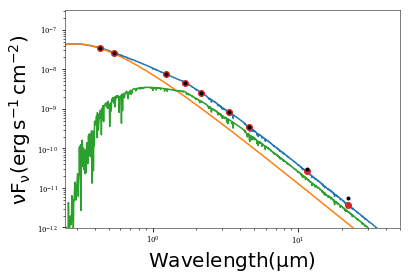

In [39]:
print (10.**revised_subj.log10Teff1guess), (10.**revised_subj.log10rdstar1guess), revised_subj.Teff2guess, revised_subj.logg2guess, (10.**revised_subj.log10rdstar2guess)

print (10.**revised_subj.log10rdstar2guess)/(10.**revised_subj.log10rdstar1guess)

plt.figure()
plt.errorbar(revised_subj.centwavs_microns_to_use, revised_subj.nuFnu_to_use, yerr=revised_subj.nuFnuerrs_to_use, fmt='k.')
if not subj.fitfail:
    plt.plot(plotting_x_vec, revised_subj.nuFnu_star_plotting_temp)
    plt.plot(plotting_x_vec, revised_subj.nuFnu_star1_plotting_temp)
    plt.plot(plotting_x_vec, revised_subj.nuFnu_star2_plotting_temp)
    #if subj.has_tycho_vmag or subj.has_tycho_bmag:
    #    plt.plot(subj.centwavs_microns_nogaia, subj.nuFnu_star, 'o')
    #else:_to_
    plt.plot(revised_subj.centwavs_microns_to_use, revised_subj.nuFnu_star, 'o')
    
ymin = float(np.floor((np.log10(min(revised_subj.nuFnu_nops))-0.5)*2.))/2.
ymax = float(np.ceil(2.*(np.log10(max(revised_subj.nuFnu_nops))+0.5)))/2.
    
plt.xlabel(r'$\mathrm{Wavelength(\mu m)}$', fontsize=20)
plt.ylabel(r'$\mathrm{\nu F_{\nu} (erg\,s^{-1}\,cm^{-2})}$', fontsize=20)


    
    #ymin = min(subj.nuFnu_star_plotting_temp)
    #ymax = max(subj.nuFnu_star_flotting_temp)
    
    
    
plt.xscale("log", nonposx='clip')
plt.yscale("log", nonposy='clip')
plt.xlim([0.25, 50.])
plt.ylim([10.**ymin, 10.**ymax])
plt.show()

In [47]:
wien_lamFlam_x = 3.90269
wien_lamFlam_factor = (h*c)/(wien_lamFlam_x*k)

def lnlike_disk_models(theta, centwavs, nuFnu, nuFnuerrs, Teff, logg):
    log10rdstar2, log10Teff1, log10rdstar1, log10Tdisk, log10xdisk = theta
    
    #Teff = 10.**log10Teff
    rdstar2 = 10.**log10rdstar2
    Teff1 = 10.**log10Teff1
    rdstar1 = 10.**log10rdstar1
    Tdisk = 10.**log10Tdisk
    xdisk = 10.**log10xdisk
    
    #Teff_use = round(Teff)
    
    #if 0.673*1.e6 in centwavs:
    #    filterzps_use = filterzps_nops
    #else:
    #    filterzps_use = filterzps_nogaia
    
    #centwavs_angstroms_num = centwavs * 1.e10
    centwavs_angstroms = centwavs * 1.e10 * u.AA
    #mags_use = np.array(mags)
                
    #magerrs_use = np.array(magerrs)
                
    fitmagsfull = btsettl_models_dict[(Teff, logg)]
                
    fitmagsuse = []
    filterzps_use = []
                
    #print centwavs
                
    for i in range(len(centwavs)):
        #print cent_wavs_dict[centwavs[i]]
        #print cent_wavs_dict[centwavs[i]]
        wavtemp = centwavs[i] * 1.e6
        if wavtemp > 1.:
            wav = round(wavtemp,3)
        else:
            wav = round(wavtemp,4)
        fitmagsuse.append(fitmagsfull[cent_wavs_dict[centwavs[i]]])
        filterzps_use.append(filterzps_dict[wav])
        
        #if centwavs[i] == cent_wavs_dict_keys[0]:
        #    magerrs_use[i] = 10.*magerrs[i]

    #print fitmagsuse
                
    result_mags = fitmagsuse - 5.*log10rdstar2
    
    fluxes_at_d = np.zeros(nuFnu.size)
    #fluxerrs_at_d = np.zeros(nuFnu.size)
        
    for i in range(fluxes_at_d.size):
        fluxes_at_d[i] = filterzps_use[i] * 10.**(-0.4*result_mags[i]) * 10.**(-23.)
        #fluxerrs_at_d[i] = 0.4 * fluxes_at_d[i] * np.log(10) * magerrs[i]
            
    nuFnu_star2_model = (c / centwavs) * fluxes_at_d
    #nuFnu_errs_star_model = (c / centwavs) * fluxerrs_at_d
    
    flux_star1_lam_temp = blackbody_lambda(centwavs_angstroms, Teff1*u.K) * np.pi * u.sr
    
    flux_star1_lam = flux_star1_lam_temp * centwavs_angstroms * u.cm * u.cm * u.s / u.erg
    
    nuFnu_star1_model = flux_star1_lam * (rdstar1**2)
    
    flux_disk_lam_temp = blackbody_lambda(centwavs_angstroms, Tdisk*u.K) * np.pi * u.sr
    
    flux_disk_lam = flux_disk_lam_temp * centwavs_angstroms * u.cm * u.cm * u.s / u.erg
    
    disk_model = flux_disk_lam * xdisk
    
    model = nuFnu_star1_model + nuFnu_star2_model + disk_model        
                
    inv_sigma2 = 1./(nuFnuerrs**2)
                
    return -0.5*np.sum((((nuFnu - model)**2)*inv_sigma2) + np.log(2.*np.pi) - np.log(inv_sigma2))

nllmodelsfull = lambda *args: -lnlike_disk_models(*args)


def lnlike_disk_blackbody(theta, wav, flux, fluxerr):
    log10Tdisk, log10xdisk = theta

    Tdisk = 10.**log10Tdisk
    xdisk = 10.**log10xdisk
    
    centwavs_angstroms = wav * 1.e10 * u.AA
    centwavs_meters = wav * u.m
    
    flux_lam_temp = blackbody_lambda(centwavs_angstroms, Tdisk*u.K) * np.pi * u.sr
    
    flux_lam = flux_lam_temp * centwavs_angstroms * u.cm * u.cm * u.s / u.erg

    model = flux_lam * xdisk
    
    #print Teff, rdstar
    #print "flux:", flux
    #print "model:", model

    inv_sigma2 = 1./(fluxerr**2)
    
    #print -0.5*np.sum((((flux - model)**2)*inv_sigma2) + np.log(2.*np.pi) - np.log(inv_sigma2))
    
    return -0.5*np.sum((((flux - model)**2)*inv_sigma2) + np.log(2.*np.pi) - np.log(inv_sigma2))

nll2 = lambda *args: -lnlike_disk_blackbody(*args)

    

def get_disk_fit(subj):
    
    nuFnu_use = subj.nuFnu_disk[-2:]
    nuFnu_err_use = subj.nuFnuerrs_to_use[-2:]
    cent_wavs_use = subj.centwavs_meters_to_use[-2:]
    
    #nuFnu_full_use = 

    rdstar_use = max([(10.**subj.log10rdstar1guess), (10.**subj.log10rdstar2guess)])
    Teff_use = max([subj.Teff2guess, (10.**subj.log10Teff1guess)])
    
    print rdstar_use
    print Teff_use
    
    Tdiskvals = np.linspace(50., 200., 10)
        
        #Also create a dictionary to store xdiskval vectors
    xdiskvals_dict = {x: None for x in Tdiskvals}
        
        #ALSO create dictionaries to store results and negative log likelihoods
    val_chi_dict = {}
    val_results_dict = {}
        
    minimization_start = time.time()
        
    for Tdiskval in Tdiskvals:
        #Define possible xdisk guesses based on the Tdisk guess
        xdiskmax = (rdstar_use**2) * 1.e-2 * ((Teff_use/Tdiskval)**4)
        xdiskmin = (rdstar_use**2) * 1.e-9 * ((Teff_use/Tdiskval)**4)
         
        xdiskvals = np.linspace(xdiskmin, xdiskmax, 11)
            
        xdiskvals_dict[Tdiskval] = xdiskvals    

        for xdiskval in xdiskvals:
            #guess = [subj.log10rdstar2guess, subj.log10Teff1guess, subj.log10rdstar1guess, np.log10(Tdiskval), np.log10(xdiskval)]
            guess = [Tdiskval, xdiskval]
                
                #result2 = minimize(nll2, guess, args = (cent_wavs_use, nuFnu_use, nuFnu_err_use))
                
                #log10Tdiskres, log10xdiskres = result2["x"]
                
                #print 
                
            reschi = -lnlike_disk_blackbody(guess, cent_wavs_use, nuFnu_use, nuFnu_err_use)
                
            val_chi_dict[(Tdiskval, xdiskval)] = reschi
                #val_results_dict[(Tdiskval, xdiskval)] = [log10Tdiskres, log10xdiskres]

                #print Tdiskval, xdiskval, log10Tdiskres, log10xdiskres, reschi

    print "Minimization cycle finished. Time:", time.time() - minimization_start
                
    sorted_chis = sorted(val_chi_dict.values())
    sorted_keys = []
        #sorted_results = []
        
    for chi in sorted_chis:
        sorted_keys.append(val_chi_dict.keys()[val_chi_dict.values().index(chi)])
            #sorted_results.append(val_results_dict[sorted_keys[-1]])
            
    num_options = len(sorted_chis)
        
    options_tested = 0
        
    fir_test_res = False
    disk_peak_res = False
        
    while not subj.good_disk_fit and options_tested < num_options:
        key = sorted_keys[options_tested]
        
        print key
           
        guess1 = [subj.log10rdstar2guess, subj.log10Teff1guess, subj.log10rdstar1guess, np.log10(key[0]), np.log10(key[1])]
            
        result2 = minimize(nllmodelsfull, guess1, args = (subj.centwavs_meters_to_use, subj.nuFnu_to_use, subj.nuFnuerrs_to_use, subj.Teff2guess, subj.logg2guess))

        log10rdstar2res, log10Teff1res, log10rdstar1res, log10Tdiskres, log10xdiskres = result2["x"]

        Tdisk_test = 10.**(log10Tdiskres)
        xdisk_test = 10.**(log10xdiskres)
            
        if Tdisk_test == 0.0:
            options_tested += 1
            continue
            
        #print options_tested, Tdisk_test, xdisk_test
            
        tdisk_test_res = Tdisk_test < Teff_use
            
        if max(subj.nuFnu_star_plotting_temp) > 0.:
            peak_star_lamFlam = max(subj.nuFnu_star_plotting_temp)
        else:
            peak_star_lambda = wien_lamFlam_factor / Teff_use
            peak_star_lamFlam = blackbody_lambda(peak_star_lambda * u.m, Teff_use*u.K) * np.pi * u.sr * (peak_star_lambda * u.m) * u.cm * u.cm * u.s / u.erg * (rdstar_use**2)

            
        fir_test = ((Tdisk_test/Teff_use)**4) * (xdisk_test/(rdstar_use**2))
            
        #print fir_test
            
        #print 'Lir/Lstar test:', fir_test
            
        fir_test_res = (fir_test < 1.)
            
        peak_disk_lambda = (wien_lamFlam_factor / Tdisk_test) * 1.e10
        #print peak_disk_lambda
            
        print 'lambda =', peak_disk_lambda, 'Tdisk =', Tdisk_test
            
        peak_disk_lamFlam = blackbody_lambda(peak_disk_lambda * u.AA, Tdisk_test*u.K) * np.pi * u.sr * (peak_disk_lambda * u.AA) * u.cm * u.cm * u.s / u.erg * xdisk_test

        if max(subj.nuFnu_star_plotting_temp) > 0.:
            peak_star_lamFlam = max(subj.nuFnu_star_plotting_temp)
        else:
            peak_star_lambda = wien_lamFlam_factor / Teff_use
            peak_star_lamFlam = blackbody_lambda(peak_star_lambda * u.m, Teff_use*u.K) * np.pi * u.sr * (peak_star_lambda * u.m) * u.cm * u.cm * u.s / u.erg * (rdstar_use**2)

        #print 'Disk peak vs star peak:', peak_disk_lamFlam, peak_star_lamFlam
                
        disk_peak_res = (peak_disk_lamFlam < peak_star_lamFlam)
            
        if (disk_peak_res and fir_test_res) or (subj.nuFnu[-1] > peak_star_lamFlam):
            subj.good_disk_fit = True
            subj.log10Tdiskguess = np.log10(Tdisk_test)
            subj.log10xdiskguess = np.log10(xdisk_test)
            subj.log10Teff1guess = log10Teff1res
            subj.log10rdstar1guess = log10rdstar1res
            subj.log10rdstar2guess = log10rdstar2res
            print (10.**subj.log10Teff1guess), (10.**subj.log10rdstar1guess), subj.Teff2guess, subj.logg2guess, (10.**subj.log10rdstar2guess), (10.**subj.log10Tdiskguess), (10.**subj.log10xdiskguess)
            #subj.fir = ((subj.Tdisk/subj.Teff)**4) * (subj.xdisk/(subj.rdstar**2))
                
        options_tested += 1
        #print options_tested
        
    if options_tested == num_options and not subj.good_disk_fit:
        print "Disk fitting failed"
        subj.nuFnu_model_plotting_temp = subj.nuFnu_star_plotting_temp
        return subj
        
    if subj.good_disk_fit:
        nuFnu_disk_points_blackbody = blackbody_lambda(subj.centwavs_meters * 1.e10 * u.AA, (10.**subj.log10Tdiskguess * u.K)) * np.pi * u.sr * (subj.centwavs_meters * 1.e10 * u.AA) * (10.**subj.log10xdiskguess) * u.cm * u.cm * u.s / u.erg
        subj.nuFnu_disk_plotting_temp_blackbody = blackbody_lambda(plotting_xvec_angstroms * u.AA, (10.**subj.log10Tdiskguess)*u.K) * np.pi * u.sr * (plotting_xvec_angstroms * u.AA) * (10.**subj.log10xdiskguess) * u.cm * u.cm * u.s / u.erg
        subj.nuFnu_model_plotting_temp_blackbody = subj.nuFnu_star_plotting_temp + subj.nuFnu_disk_plotting_temp_blackbody          

        subj.nuFnu_disk_plotting_temp = subj.nuFnu_disk_plotting_temp_blackbody
        subj.nuFnu_model_plotting_temp = subj.nuFnu_model_plotting_temp_blackbody
         
        #print nuFnu_disk_points
        #print subj.nuFnu_disk
        #nuFnu_disk_points = blackbody_lambda(cent_wavs_use*1.e10 *u.AA, subj.Tdisk * u)
        
        #print np.interp(subj.centwavs_meters*1.e10, plotting_xvec_angstroms, subj.nuFnu_disk_plotting)

        #subj.nuFnu_disk = subj.nuFnu - subj.nuFnu_star
   
        #subj.nuFnu_disk_errs = subj.nuFnuerrs
    
        return subj
            
revised_subj.good_disk_fit = False
completed_subj = get_disk_fit(revised_subj)
print "Done"

6.26920339612e-10
14677.170378
Minimization cycle finished. Time: 0.822999954224
(50.0, 2.9181932319171258e-18)
lambda = 99843.8910027 Tdisk = 369.23940321
14247.8914068 1.75392361146e-10 4000.0 5.5 6.2326740651e-10 369.23940321 3.41917187552e-18
Done


5.01336539641e-05


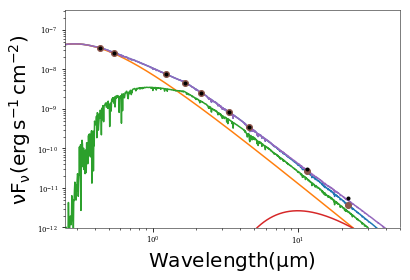

In [51]:
print ((10.**completed_subj.log10xdiskguess)/((10.**completed_subj.log10rdstar1guess)**2))*(((10.**completed_subj.log10Tdiskguess)/(10.**completed_subj.log10Teff1guess))**4)

plt.figure()
plt.errorbar(revised_subj.centwavs_microns_to_use, revised_subj.nuFnu_to_use, yerr=revised_subj.nuFnuerrs_to_use, fmt='k.')
if not subj.fitfail:
    plt.plot(plotting_x_vec, completed_subj.nuFnu_star_plotting_temp)
    plt.plot(plotting_x_vec, completed_subj.nuFnu_star1_plotting_temp)
    plt.plot(plotting_x_vec, completed_subj.nuFnu_star2_plotting_temp)
    plt.plot(plotting_x_vec, completed_subj.nuFnu_disk_plotting_temp)
    plt.plot(plotting_x_vec, completed_subj.nuFnu_model_plotting_temp_blackbody)
    #if subj.has_tycho_vmag or subj.has_tycho_bmag:
    #    plt.plot(subj.centwavs_microns_nogaia, subj.nuFnu_star, 'o')
    #else:_to_
    plt.plot(revised_subj.centwavs_microns_to_use, revised_subj.nuFnu_star, 'o')
    
ymin = float(np.floor((np.log10(min(revised_subj.nuFnu_nops))-0.5)*2.))/2.
ymax = float(np.ceil(2.*(np.log10(max(revised_subj.nuFnu_nops))+0.5)))/2.
    
plt.xlabel(r'$\mathrm{Wavelength(\mu m)}$', fontsize=20)
plt.ylabel(r'$\mathrm{\nu F_{\nu} (erg\,s^{-1}\,cm^{-2})}$', fontsize=20)


    
    #ymin = min(subj.nuFnu_star_plotting_temp)
    #ymax = max(subj.nuFnu_star_flotting_temp)
    
    
    
plt.xscale("log", nonposx='clip')
plt.yscale("log", nonposy='clip')
plt.xlim([0.25, 50.])
plt.ylim([10.**ymin, 10.**ymax])
plt.show()

In [61]:
def lnprior(theta,Teff2):
    log10rdstar2, log10Teff1, log10rdstar1, log10Tdisk, log10xdisk = theta
    
    #Teff = 10.**log10Teff
    rdstar2 = 10.**log10rdstar2
    Tdisk = 10.**log10Tdisk
    xdisk = 10.**log10xdisk
    
    #tefflogg = (Teff, logg)
    
    #print tefflogg
    
    #print keylist
    
    #Tefflogg_flag = False
    
    #for key in keylist:
    #    if (Teff - key[0] < 1.e-10) and (logg==key[1]):
    #        Tefflogg_flag = True
    #        break
            
    
    #Tefflogg_flag = (Teff, logg) in keylist
    
    rdstar_flag = rdstar2 < 1.22e-7
    
    Tdisk_flag = Tdisk < Teff2
    
    lir_lstar_flag = (((Tdisk/Teff2)**4) * (xdisk/(rdstar2**2))) < 1.
    
    #print 'Tefflogg', Tefflogg_flag
    #print 'rdstar', rdstar_flag
    #print 'Tdisk', Tdisk_flag
    #print 'lir/lstar', lir_lstar_flag
    
    if rdstar_flag and Tdisk_flag and lir_lstar_flag:
        return 0.0
    else:
        return -np.inf

def lnprob(theta, centwavs, nuFnu, nuFnuerrs, Teff2, logg2):
    lp = lnprior(theta, Teff2)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike_disk_models(theta, centwavs, nuFnu, nuFnuerrs, Teff2, logg2)


subjs_with_mcmc = []
mcmc_run_start_time = time.time()

print 'Starting MCMC', mcmc_run_start_time

print completed_subj.zooniverse_id, subj.wiseid
    
cent_wavs_full_use = subj.centwavs_meters_to_use
nuFnu_full_use = subj.nuFnu_to_use
nuFnu_full_err_use = subj.nuFnuerrs_to_use
    
    
ndim, nwalkers = 5, 100
        
res = lnprob([completed_subj.log10rdstar2guess, completed_subj.log10Teff1guess, completed_subj.log10rdstar1guess, completed_subj.log10Tdiskguess, completed_subj.log10xdiskguess], cent_wavs_full_use, nuFnu_full_use, nuFnu_full_err_use, subj.Teff2guess, subj.logg2guess)
pos = [[completed_subj.log10rdstar2guess, completed_subj.log10Teff1guess, completed_subj.log10rdstar1guess, completed_subj.log10Tdiskguess, completed_subj.log10xdiskguess] +1e-4*np.random.randn(ndim) for i in range(nwalkers)]
        
completed_subj.sampler = emcee.EnsembleSampler(nwalkers, 5, lnprob, args=(cent_wavs_full_use, nuFnu_full_use, nuFnu_full_err_use, completed_subj.Teff2guess, completed_subj.logg2guess))
completed_subj.sampler.run_mcmc(pos, 1000)

print "Done,", time.time(), time.time()-mcmc_run_start_time




Starting MCMC 1519609283.14
AWI00062ic J030854.20-185809.1
Done, 1519610707.74 1424.59500003


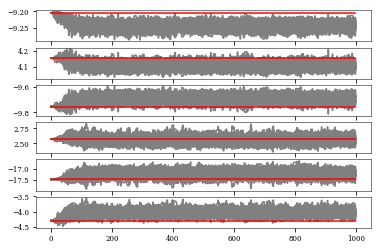

In [62]:
plt.figure()
f, axarr = plt.subplots(6, sharex=True)
for i in range(nwalkers):
    axarr[0].plot(np.arange(1000.), ((completed_subj.sampler.chain[i,:,0])),'grey')
    axarr[1].plot(np.arange(1000.), ((completed_subj.sampler.chain[i,:,1])),'grey')
    axarr[2].plot(np.arange(1000.), ((completed_subj.sampler.chain[i,:,2])),'grey')
    axarr[3].plot(np.arange(1000.), ((completed_subj.sampler.chain[i,:,3])),'grey')
    axarr[4].plot(np.arange(1000.), ((completed_subj.sampler.chain[i,:,4])),'grey')

    Teff1_vec = 10.**(completed_subj.sampler.chain[i,:,1])
    rdstar_vec = 10.**(completed_subj.sampler.chain[i,:,2])
    Tdisk_vec = 10.**(completed_subj.sampler.chain[i,:,3])
    xdisk_vec = 10.**(completed_subj.sampler.chain[i,:,4])
    
    lir_lstar_vec = ((Tdisk_vec/Teff1_vec)**4)*(xdisk_vec/(rdstar_vec**2))
    
    axarr[5].plot(np.arange(1000.), np.log10(lir_lstar_vec),'grey')

axarr[0].plot(np.arange(1000.), np.ones(1000)*(completed_subj.log10rdstar2guess), 'r')
axarr[1].plot(np.arange(1000.), np.ones(1000)*(completed_subj.log10Teff1guess), 'r')
axarr[2].plot(np.arange(1000.), np.ones(1000)*(completed_subj.log10rdstar1guess), 'r')
axarr[3].plot(np.arange(1000.), np.ones(1000)*(completed_subj.log10Tdiskguess), 'r')
axarr[4].plot(np.arange(1000.), np.ones(1000)*(completed_subj.log10xdiskguess), 'r')

Teff_guess = 10.**(completed_subj.log10Teff1guess)
rdstar_guess = 10.**(completed_subj.log10rdstar1guess)
Tdisk_guess = 10.**(completed_subj.log10Tdiskguess)
xdisk_guess = 10.**(completed_subj.log10xdiskguess)

lir_lstar_guess = ((Tdisk_guess/Teff_guess)**4)*(xdisk_guess/(rdstar_guess ** 2))
log10lir_lstar_guess = np.log10(lir_lstar_guess)

axarr[5].plot(np.arange(1000.), np.ones(1000)*log10lir_lstar_guess, 'r')
    
plt.show()

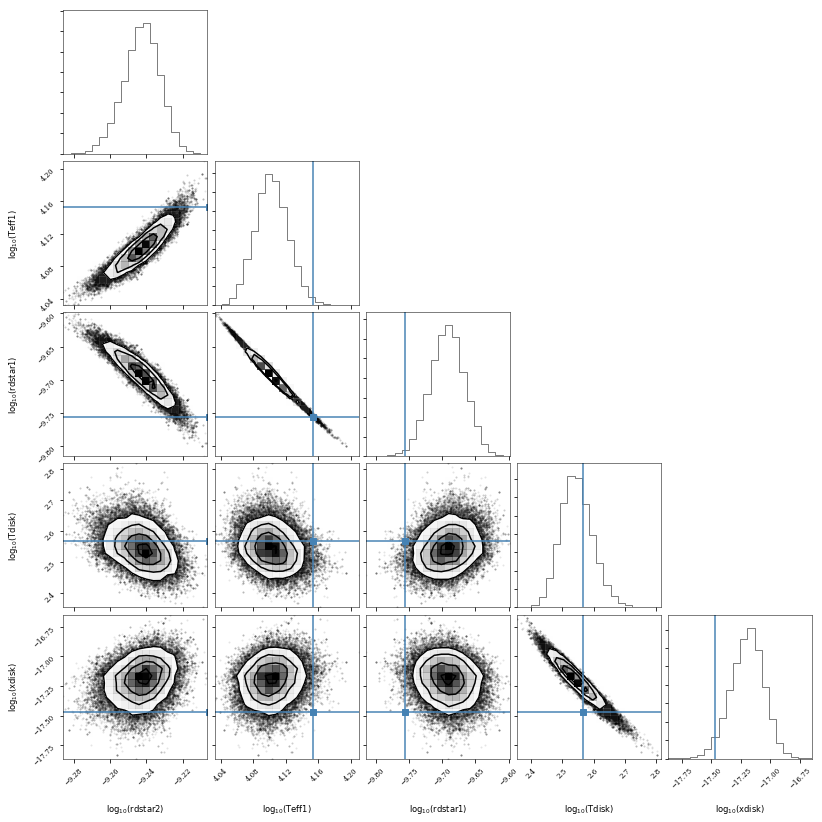

In [65]:
samples = completed_subj.sampler.chain[:,200:,:].reshape((-1, ndim))

import corner
fig = corner.corner(samples, labels=["$\log_{10}(\mathrm{rdstar2})$", "$\log_{10}(\mathrm{Teff1})$", "$\log_{10}(\mathrm{rdstar1})$", "$\log_{10}(\mathrm{Tdisk})$", "$\log_{10}(\mathrm{xdisk})$"],
                      truths=[completed_subj.log10rdstar2guess, completed_subj.log10Teff1guess, completed_subj.log10rdstar1guess, completed_subj.log10Tdiskguess, completed_subj.log10xdiskguess])

plt.show()

In [68]:
final_samples = np.zeros(samples.shape)

final_samples[:,0] = 10.**samples[:,0]
final_samples[:,1] = 10.**samples[:,1]
final_samples[:,2] = 10.**samples[:,2]
final_samples[:,3] = 10.**samples[:,3]
final_samples[:,4] = 10.**samples[:,4]

completed_subj.rdstar2 = np.percentile(final_samples[:,0],50.)
completed_subj.rdstar2errhigh = np.percentile(final_samples[:,0],84.) - completed_subj.rdstar2
completed_subj.rdstar2errlow = completed_subj.rdstar2 - np.percentile(final_samples[:,0],16.)

completed_subj.Teff1 = np.percentile(final_samples[:,1],50.)
completed_subj.Teff1errhigh = np.percentile(final_samples[:,1],84.) - completed_subj.Teff1
completed_subj.Teff1errlow = completed_subj.Teff1 - np.percentile(final_samples[:,1],16.)

completed_subj.rdstar1 = np.percentile(final_samples[:,2],50.)
completed_subj.rdstar1errhigh = np.percentile(final_samples[:,2],84.) - completed_subj.rdstar1
completed_subj.rdstar1errlow = completed_subj.rdstar1 - np.percentile(final_samples[:,2],16.)

completed_subj.Tdisk = np.percentile(final_samples[:,3],50.)
completed_subj.Tdiskerrhigh = np.percentile(final_samples[:,3],84.) - completed_subj.Tdisk
completed_subj.Tdiskerrlow = completed_subj.Tdisk - np.percentile(final_samples[:,3],16.)

completed_subj.xdisk = np.percentile(final_samples[:,4],50.)
completed_subj.xdiskerrhigh = np.percentile(final_samples[:,4],84.) - completed_subj.xdisk
completed_subj.xdiskerrlow = completed_subj.xdisk - np.percentile(final_samples[:,4],16.)

lir_lstar_samples = (final_samples[:,4]/(final_samples[:,2]**2)) * ((final_samples[:,3]/final_samples[:,1])**4)

completed_subj.lir_lstar = np.percentile(lir_lstar_samples,50.)
completed_subj.lir_lstar_errhigh = np.percentile(lir_lstar_samples, 84.) - completed_subj.lir_lstar
completed_subj.lir_lstar_errlow = completed_subj.lir_lstar - np.percentile(lir_lstar_samples, 16.)

print completed_subj.Teff1, completed_subj.Teff1errlow, completed_subj.Teff1errhigh
print completed_subj.rdstar1, completed_subj.rdstar1errlow, completed_subj.rdstar1errhigh
print completed_subj.Teff2guess
print completed_subj.logg2guess
print completed_subj.rdstar2, completed_subj.rdstar2errlow, completed_subj.rdstar2errhigh
print completed_subj.Tdisk, completed_subj.Tdiskerrlow, completed_subj.Tdiskerrhigh
print completed_subj.xdisk, completed_subj.xdiskerrlow, completed_subj.xdiskerrhigh
print completed_subj.lir_lstar, completed_subj.lir_lstar_errlow, completed_subj.lir_lstar_errhigh

12654.077128 562.257442425 621.654663416
2.03399920973e-10 1.18256759431e-11 1.21558177619e-11
4000.0
5.5
5.72419209313e-10 1.37213539657e-11 1.2573700804e-11
349.371488111 36.3133390594 46.5285845563
6.43988520712e-18 1.84788252338e-18 2.26802375765e-18
9.07884926344e-05 1.73363757647e-05 2.19622719349e-05


In [78]:
def plot_number_formatting(input):
    '''Formats exponential numbers in normal scientific notation for plotting purposes'''

    teststring = '%.4e' % input
    index = teststring.index('e')
    backindex = index - len(teststring)
    firstpartfloat = float(teststring[:backindex])
    secondpartint = int(teststring[(backindex+1):])

    #formatted_string = '$%.4f \times 10^{%d}$' % (firstpartfloat, secondpartint)

    return firstpartfloat, secondpartint

def plot_subj(subj):
    plt.figure()
    
    plt.rcParams['xtick.labelsize'] = 18
    plt.rcParams['ytick.labelsize'] = 18
    params = {'text.usetex': False, 'mathtext.fontset': 'stixsans'}
    plt.rcParams.update(params)
        
    plt.gcf().subplots_adjust(left = 0.21)
    plt.gcf().subplots_adjust(right=0.96)
    plt.gcf().subplots_adjust(top=0.96)
    plt.gcf().subplots_adjust(bottom=0.18)
    
    #ax = plt.subplot
    
    plt.errorbar(subj.centwavs_microns_to_use, subj.nuFnu_to_use, yerr=subj.nuFnuerrs_to_use, fmt='ko', markersize=5.)
        
    #plt.plot(subj.centwavs_microns, subj.nuFnu_star, 'r.')
        
    #print subj.nuFnu
    #print subj.nuFnu_star
    

    plt.xscale('log', nonposx='clip')
    plt.yscale('log', nonposy='clip')
    
    min_nuFnu_logs = min(np.log10(subj.nuFnu))
    max_nuFnu_logs = max(np.log10(subj.nuFnu_star1_plotting))

    ymin = float(np.floor((min_nuFnu_logs-1.5)*2.))/2.
    ymax = float(np.ceil(2.*(max_nuFnu_logs+0.5)))/2.

    #if subj.good_disk_fit:
    plt.plot(plotting_x_vec, subj.nuFnu_star1_plotting, linestyle=':', label='First Stellar Model')
    plt.plot(plotting_x_vec, subj.nuFnu_star2_plotting, linestyle=':', label='Second Stellar Model')
    plt.plot(plotting_x_vec, subj.nuFnu_disk_plotting, linestyle='--', label='Disk Blackbody')
    plt.plot(plotting_x_vec, subj.nuFnu_model_plotting, label='Total')
    #plt.annotate(subj.wiseid+'\n'+'Tstar = %.0f K\nTdisk = %.0f K\nLir/Lstar = %.4e' % (subj.Teff, subj.Tdisk, subj.fir), xy=(0.55, 0.75), xycoords = 'axes fraction', fontsize=12)

    #else:
    #    plt.plot(plotting_x_vec, subj.nuFnu_model_plotting)
    #    #plt.annotate(subj.wiseid+'\n'+'Tstar = %.0f K\nNo good disk fit' % (subj.Teff), xy=(0.55, 0.75), xycoords = 'axes fraction', fontsize=12)

    plt.xlim([0.25, 100.])
    plt.ylim([10.**(ymin), 10.**(ymax)])

    #if subj.use_models:
    #    if subj.fir > 0.01:
    #        plt.annotate(r'$\mathrm{'+subj.wiseid+'}$' '\n' r'$T_{\mathrm{star}} = %.0f$ K' '\n' r'$T_{\mathrm{disk}}=%.0f$ K' '\n' r'$L_{\mathrm{ir}}/L_{\mathrm{star}} = %.4f$' % (subj.Teff, subj.Tdisk, subj.fir), xy=(0.52, 0.7), xycoords = 'axes fraction', fontsize=16)
    #    else:
    #        plt.annotate(r'$\mathrm{'+subj.wiseid+'}$' '\n' r'$T_{\mathrm{star}} = %.0f$ K' '\n' r'$T_{\mathrm{disk}}=%.0f$ K' '\n' r'$L_{\mathrm{ir}}/L_{\mathrm{star}} = %.4f \times 10^{%d}$' % (subj.Teff, subj.Tdisk, plot_number_formatting(subj.fir)[0], plot_number_formatting(subj.fir)[1]), xy=(0.52, 0.7), xycoords = 'axes fraction', fontsize=16)

    #else:
    #    if subj.fir > 0.01:
    #        plt.annotate(r'$\mathrm{'+subj.wiseid+'}$' '\n' r'$T_{\mathrm{star}} = %.0f$ K' '\n' r'$T_{\mathrm{disk}}=%.0f$ K' '\n' r'$L_{\mathrm{ir}}/L_{\mathrm{star}} = %.4f$' % (subj.Teff, subj.Tdisk, subj.fir), xy=(0.52, 0.7), xycoords = 'axes fraction', fontsize=16)
    #    else:
    plt.annotate(r'$\mathrm{'+subj.wiseid+'}$' '\n' r'$T_{\mathrm{star1}} = %.0f \mathrm{K}$' '\n' r'$T_{\mathrm{star2}} = %.0f \mathrm{K}$' '\n' r'$T_{\mathrm{disk}}=%.0f \mathrm{K}$' '\n' r'$L_{\mathrm{ir}}/L_{\mathrm{star}} = %.4f \times 10^{%d}$' % (subj.Teff1, subj.Teff2guess, subj.Tdisk, plot_number_formatting(subj.lir_lstar)[0], plot_number_formatting(subj.lir_lstar)[1]), xy=(0.55, 0.65), xycoords = 'axes fraction', fontsize=14)


        
    plt.legend(loc='lower left',fontsize=12)
    
    
    
    plt.xlabel(r'$\mathrm{Wavelength(\mu m)}$', fontsize=24)
    plt.ylabel(r'$\mathrm{\nu F_{\nu} (erg\,s^{-1}\,cm^{-2})}$', fontsize=24)
    
    #if len(subjs_with_star_fits) < 2:
    plt.savefig('sedplotting_no_unc/'+subj.zooniverse_id+'_modelfit.pdf')
    
    plt.close()
    
    #plt.show()
    return

teffpull = '0'+str(int(subj.Teff2guess/100))
loggpull = str(subj.logg2guess)
        
spect_file = 'BTSettlstuff_use/BT-Settl_M-0.0a+0.0/lte'+teffpull+'.0-'+loggpull+'-0.0a+0.0.BT-Settl.spec.7'
        
spec_X, spec_S, spec_dict = fluxdrive_plot(spect_file,1)
flux_spec_S = spec_X * spec_S * (subj.rdstar2**2)
completed_subj.nuFnu_star2_plotting = np.interp(plotting_xvec_angstroms, spec_X, flux_spec_S)

completed_subj.nuFnu_star1_plotting = blackbody_lambda(plotting_xvec_angstroms * u.AA, (completed_subj.Teff1)*u.K) * np.pi * u.sr * (plotting_xvec_angstroms * u.AA) * ((completed_subj.rdstar1)**2) * u.cm * u.cm * u.s / u.erg

completed_subj.nuFnu_disk_plotting = blackbody_lambda(plotting_xvec_angstroms * u.AA, (completed_subj.Tdisk)*u.K) * np.pi * u.sr * (plotting_xvec_angstroms * u.AA) * ((completed_subj.xdisk)) * u.cm * u.cm * u.s / u.erg

completed_subj.nuFnu_model_plotting = completed_subj.nuFnu_star1_plotting + completed_subj.nuFnu_star2_plotting + completed_subj.nuFnu_disk_plotting

plot_subj(completed_subj)